tgb - 5/20/2019 - The goal is to study the relationship between precipitation and column water vapor using neural networks. Because neural networks are fast, non-linear models of physical relationships, they can capture behavior that would otherwise necessit computationally expensive simulations. Three steps:  
1) Reproduce the tropical Precipitation - Column Water Vapor curve with neural networks  
2) Capture variability of temperature and water vapor using principle component analysis  
3) Feed the main modes of variability to the neural network to see which modes of variability reproduce the P-Q relationship

# 1) Load CBRAIN modules and aquaplanet dataset

## 1.1) Load CBRAIN modules

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


Load coordinates

In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

## 1.2) Evaluate P-Q relationship from data

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

Load the NNLU network as an example

In [4]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/NNA0.01.h5'
NN['NNA0.01'] = load_model(path,custom_objects=dict_lay)
md['NNA0.01'] = ModelDiagnostics(NN,config_fn,data_fn)
# NNL0.01
path = TRAINDIR+'HDF5_DATA/NNL0.01.h5'
NN['NNL0.01'] = load_model(path,custom_objects=dict_lay)
md['NNL0.01'] = ModelDiagnostics(NN,config_fn,data_fn)
# Jordan network
path = TRAINDIR+'HDF5_DATA/JordanNNAU01.h5'
NN['J01'] = load_model(path,custom_objects=dict_lay)
md['J01'] = ModelDiagnostics(NN,config_fn,data_fn)

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
NNa = ['NNA0.01','NNL0.01','J01']

In [104]:
# User's choice
latTROP = [-20,20]
Nt = 100
iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))

P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# Initialization
CWVtrop = np.zeros((len(iTROP[0]),len(coor.lon),1))
QVtrop = np.zeros((len(iTROP[0]),len(coor.lon),len(coor.lev),1))
Ttrop = np.copy(QVtrop)
xtrop = np.zeros((len(iTROP[0]),len(coor.lon),304,1))
PRECtrop = np.zeros((len(iTROP[0]),len(coor.lon),1))

PREC_NN = {}
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = np.zeros((len(iTROP[0]),len(coor.lon),1))

for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md[NNname] # Reference model diagnostic object
    # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
    X, truth = m.valid_gen[itime]
    PRECIP = (np.sum(truth.values[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
    # 2) Save mean tropical input
    xgeo = m.reshape_ngeo(m.valid_gen.input_transform.inverse_transform(X).values)[iTROP,:,:]
    xtrop = np.concatenate((xtrop,np.expand_dims(xgeo[0,:,:,:],axis=3)),axis=3)
    # 3) Water vapor
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)[iTROP,:,:]
    QVtrop = np.concatenate((QVtrop,np.expand_dims(QVgeo[0,:,:,:],axis=3)),axis=3)
    CWVgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*QV/G,axis=1),axis=1))
    CWVtrop = np.concatenate((CWVtrop,CWVgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # 4) Precipitation
    PRECgeo = m.reshape_ngeo(PRECIP)
    PRECtrop = np.concatenate((PRECtrop,PRECgeo[iTROP,:,:][0,:,:,:]),axis=2)
    # 5) Temperature
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    Tgeo = m.reshape_ngeo(T.values)[iTROP,:,:]
    Ttrop = np.concatenate((Ttrop,np.expand_dims(Tgeo[0,:,:,:],axis=3)),axis=3)
    # 5) Precipitation from NN prediction
    for iNN,NNname in enumerate(NNa):
        pred = md[NNname].model[NNname].predict_on_batch(X)
        PRECIP_NN = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
        PREC_NN[NNname] = np.concatenate((
            PREC_NN[NNname],
            md[NNname].reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:]),
            axis=2)

# Remove initial zero
QVtrop = QVtrop[:,:,:,1:]
Ttrop = Ttrop[:,:,:,1:]
CWVtrop = CWVtrop[:,:,1:]
PRECtrop = PRECtrop[:,:,1:]
xtrop = xtrop[:,:,:,1:]
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]

In [105]:
# import matplotlib.pyplot as plt
# plt.scatter(CWVtrop,PRECtrop,color='r')
# plt.scatter(CWVtrop,PREC_NN,color='b')

In [106]:
# Histogram parameters
Nbin = 100
CWVmin = 20
CWVmax = 70

In [107]:
CWVm = np.zeros((Nbin-1,1))
Pm = np.copy(CWVm)
PNNm = {}
for iNN,NNname in enumerate(NNa):
    PNNm[NNname] = np.copy(Pm)

for ibin,edge in enumerate(np.linspace(CWVmin,CWVmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtrop,weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        Pm[ibin-1] = np.average(PRECtrop,weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        for iNN,NNname in enumerate(NNa):
            PNNm[NNname][ibin-1] = np.average(
                PREC_NN[NNname],
                weights=(CWVtrop>=edge_left)*(CWVtrop<edge))
        
    edge_left = edge

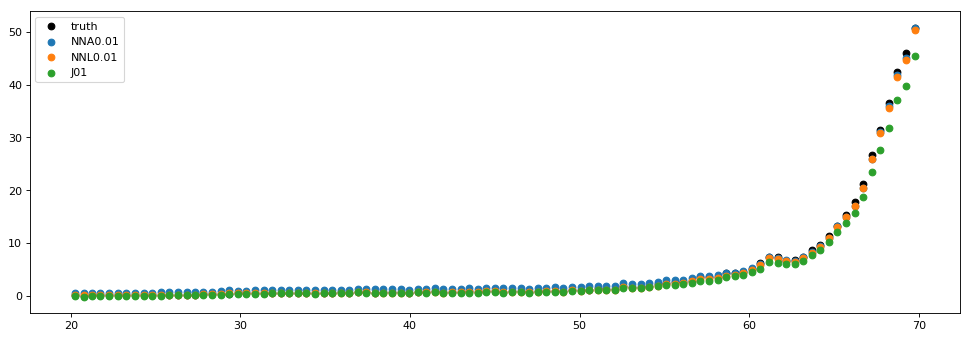

In [108]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(CWVm,Pm,color='k',label='truth')
for iNN,NNname in enumerate(NNa):
    plt.scatter(CWVm,PNNm[NNname],label=NNname)
plt.legend()

## 1.3 Build conditional P-Q relationship from data  
tgb - 5/20/2019 - Not very convenient in Python... Maybe best to accumulate and calculate conditional statistics at the end

In [109]:
# # Histogram parameters
# Nbin = 100
# CWVmin = 0
# CWVmax = 80

In [110]:
# User's choice
# latTROP = [-20,20]
# iTROP = np.where((coor.lat>=latTROP[0])*(coor.lat<=latTROP[1]))

# P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# # Allocate histogram array
# CWVhist = np.zeros(Nbin)
# Phist = np.copy(CWVhist)
# P_NNhist = np.copy(Phist)

# for itime in range(2):
#     print('itime=',itime)
#     # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
#     X, truth = md.valid_gen[itime]
#     PRECIP = (np.sum(truth.values[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
#     pred = md.model.predict_on_batch(X)
#     PRECIP_NN = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
#     # 2) Calculate column water vapor 
#     QV = md.valid_gen.input_transform.inverse_transform(X)[:,md.get_input_var_idx('QBP')]
#     CWVgeo = md.reshape_ngeo(np.expand_dims(np.sum(md.dP(itime)*QV/G,axis=1),axis=1))
#     # 3) Calculate true and predicted histogram
#     # True column water vapor histogram
#     average_speed = numpy.average(speeds, weights=(speeds > 0))
#     hist,edges = np.histogram(CWVgeo[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     CWVhist += hist
#     hist,edges = np.histogram(md.reshape_ngeo(PRECIP)[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     Phist += hist
#     hist,edges = np.histogram( md.reshape_ngeo(PRECIP_NN)[iTROP,:,:][0,:,:,:],
#                               range=(CWVmin,CWVmax),bins=Nbin)
#     P_NNhist += hist

# bins = 0.5*(edges[1:]+edges[:-1])

In [111]:
# A = CWVgeo[iTROP,:,:][0,:,:,:]
# A.flatten().shape
# B = A.flatten()
# CWVm = np.average(B, weights=((B>0)*(B<25)))

# 2) Principle component analysis of temperature and water vapor

## 2.1) Start with water vapor PCA: We will use this PCA as our main basis

tgb - 5/20/2019 - Uses the answer of https://stats.stackexchange.com/questions/235882/pca-in-numpy-and-sklearn-produces-different-results

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [113]:
QVtrop.shape
H = np.concatenate((L_V*QVtrop,C_P*Ttrop),axis=2)

In [114]:
Hswap = np.swapaxes(H,2,3)
Hswap.shape

(14, 128, 100, 60)

In [115]:
S = Hswap.shape
Htopca = Hswap.reshape(S[0]*S[1]*S[2],S[3])
Htopca.shape

(179200, 60)

tgb - 5/20/2019 - Using https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca

In [116]:
pca = decomposition.PCA(n_components=60)
pca.fit(Htopca)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [117]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_[1]

[6.63140809e-01 7.37258937e-02 6.14208744e-02 5.79297014e-02
 3.43026701e-02 1.47907194e-02 1.27583182e-02 1.10923544e-02
 8.70883286e-03 7.84014175e-03 7.17892269e-03 6.12692473e-03
 5.78602218e-03 4.62277698e-03 4.14341640e-03 3.87049875e-03
 3.18697802e-03 2.81618763e-03 2.26620376e-03 1.80671564e-03
 1.73669645e-03 1.44883636e-03 1.32681914e-03 1.19906727e-03
 1.14713657e-03 8.27510642e-04 7.01986130e-04 6.07239076e-04
 5.59653604e-04 5.14325993e-04 4.26424408e-04 3.97388140e-04
 3.10613672e-04 2.62003682e-04 2.13469458e-04 1.67370948e-04
 1.49753060e-04 1.40283811e-04 1.25632428e-04 6.58496245e-05
 6.27866926e-05 3.61863708e-05 2.67854001e-05 1.22904673e-05
 8.48174254e-06 5.94556114e-06 2.33037063e-06 1.86875175e-06
 2.65963904e-07 3.18580173e-08 3.68393116e-09 4.13991899e-10
 1.17177885e-10 4.19896859e-11 1.85007405e-11 8.93420589e-12
 6.89204230e-12 3.38118579e-12 1.58375097e-12 3.40729392e-13]


0.0737258936524773

In [118]:
pca.components_.shape

(60, 60)

Text(0, 0.5, 'Pressure [hPa]')

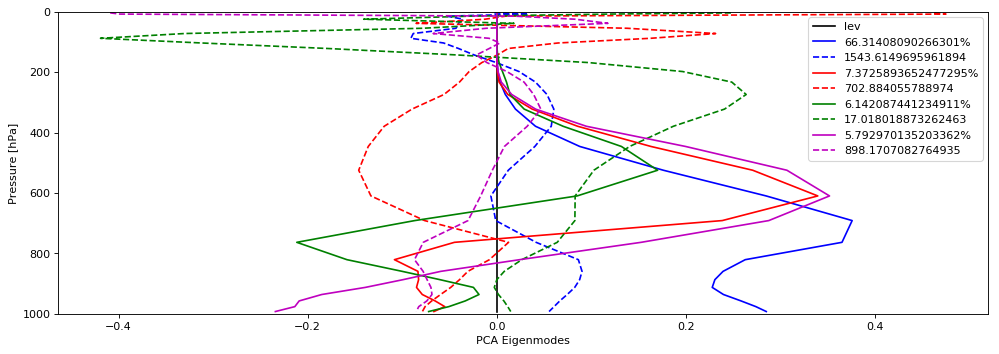

In [119]:
COL = ['b','r','g','m']
INT = {}
dPm = m.dP(1).mean(axis=0)

plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
# Plot moisture and temperature modes separately
plt.plot(0*coor.lev**0,coor.lev,color='k')
for icom in range(4):
    
    INT[icom] = np.sum(np.transpose(np.expand_dims(dPm,axis=1))*
                       pca.components_[icom,:30]/G)
    pca.components_[icom,:] = pca.components_[icom,:]*np.sign(INT[icom])
    INT[icom] = np.abs(INT[icom])
    
    plt.plot(pca.components_[icom,:30],coor.lev,color=COL[icom],
             label=(str(100*pca.explained_variance_ratio_[icom])+'%'))
    plt.plot(pca.components_[icom,30:],coor.lev,color=COL[icom],linestyle='--',
             label=str(INT[icom]))
plt.legend(); plt.ylim((0,1000))
plt.gca().invert_yaxis()
plt.xlabel('PCA Eigenmodes')
plt.ylabel('Pressure [hPa]')

## 2.2) Vary mean water vapor and temperature profile using PCA

In [120]:
# Calculate mean normalized MSE profile
Hmean = Htopca.mean(axis=0)
# Obtain water vapor and temperature profiles from it
QVmean = Hmean[:30]/L_V
Tmean = Hmean[30:]/C_P

In [121]:
INT

{0: 1543.6149695961894,
 1: 702.884055788974,
 2: 17.018018873262463,
 3: 898.1707082764935}

Text(0, 0.5, 'Pressure [hPa]')

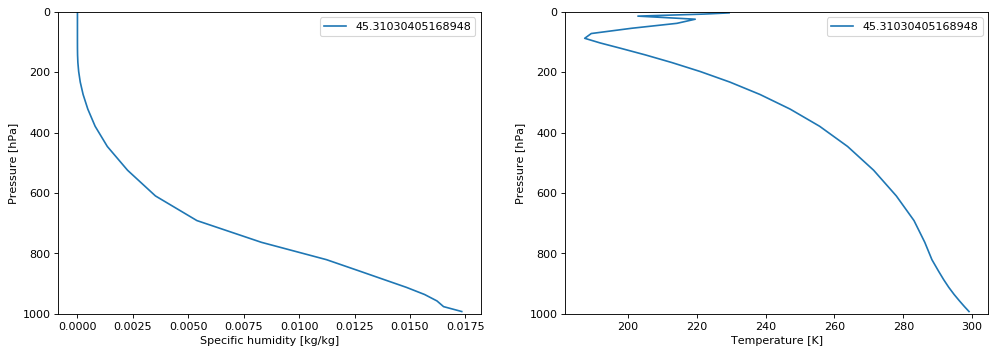

In [122]:
# Plot mean water vapor and temperature profiles to check
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
# Mean column water vapor
QINTm = np.sum(np.transpose(np.expand_dims(dPm,axis=1))*
               QVmean/G)
# Plot moisture and temperature modes separately
plt.subplot(1,2,1)
plt.plot(QVmean,coor.lev,label=str(QINTm))
plt.legend(); plt.ylim((0,1000))
plt.gca().invert_yaxis()
plt.xlabel('Specific humidity [kg/kg]')
plt.ylabel('Pressure [hPa]')

plt.subplot(1,2,2)
plt.plot(Tmean,coor.lev,label=str(QINTm))
plt.legend(); plt.ylim((0,1000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')

tgb - 5/21/2019 - CAREFUL - If the inputs are averaged in input space, then feeding them to the neural networks often lead to negative precipitation values... Now trying to average the inputs in physical space. 
This does NOT solve the problem... Maybe the network is good at making exact predictions on the training and average predictions outside of teh training set. This suggests perturbing ALL the input profiles following the PCA and THEN averaging over the predictions to get the conditional curve.

icom= 0  & INT= 1543.6149695961894
icom= 1  & INT= 702.884055788974
icom= 2  & INT= 17.018018873262463
icom= 3  & INT= 898.1707082764935


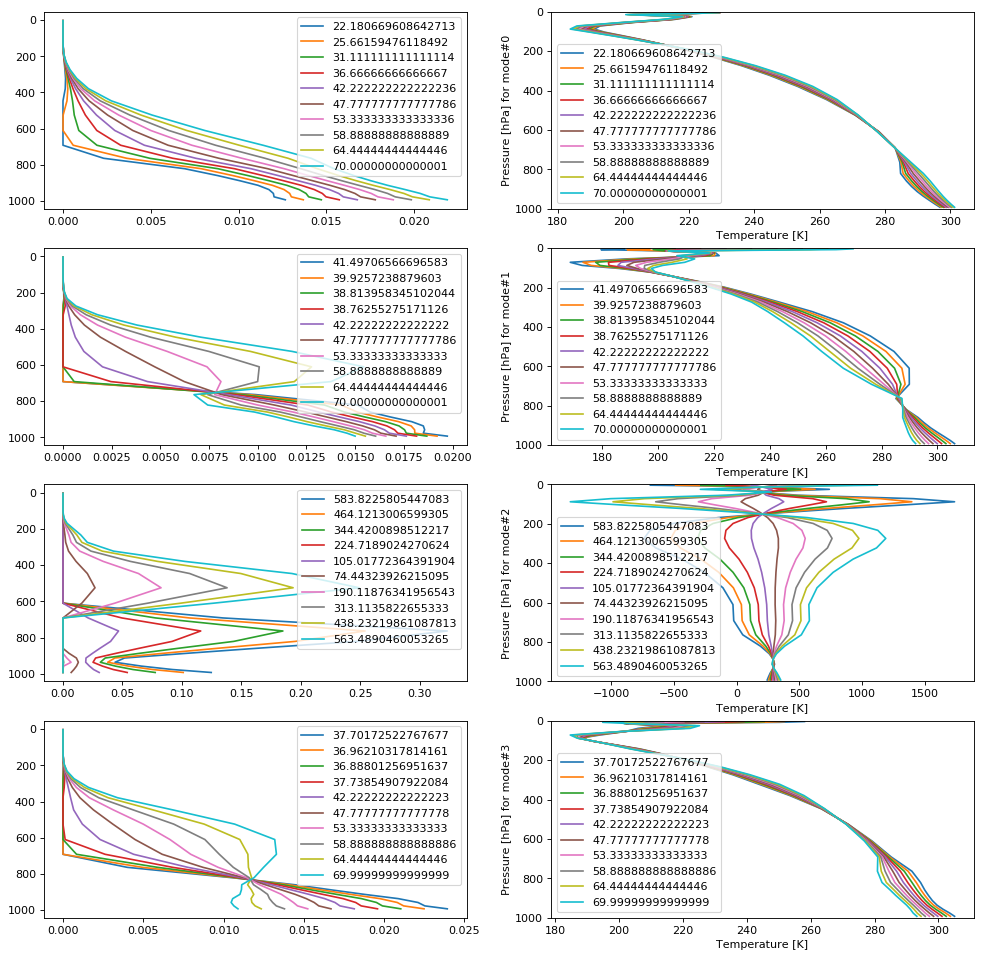

In [140]:
CWVa = np.linspace(CWVmin,CWVmax,num=10)
QINT = np.zeros((4,len(CWVa)))
P_NN = {}; P_MEAN = {};
for iNN,NNname in enumerate(NNa):
    P_NN[NNname] = np.zeros((4,len(CWVa)))

plt.figure(num=None, figsize=(15,15), dpi=80, facecolor='w', edgecolor='k')
for icom in range(4):
    print('icom=',icom,' & INT=',INT[icom])
    axQ = plt.subplot(4,2,2*icom+1)
    axT = plt.subplot(4,2,2*icom+2)
    
    for iCWV,CWV in enumerate(CWVa):
        coef = (CWV-QINTm)/INT[icom] # Coefficient to multiply the mode by
        QV = QVmean+coef*pca.components_[icom,:30]
        QV = np.maximum(QV,np.zeros(QV.shape))
        QINT[icom,iCWV] = np.sum(np.transpose(np.expand_dims(dPm,axis=1))*
                                 QV/G) # Recalculate column water vapor to check
        T = Tmean+coef*L_V*pca.components_[icom,30:]/C_P
        
        # Make prediction using neuran networks
        for iNN,NNname in enumerate(NNa):
            X = m.valid_gen.input_transform.transform(np.mean(xtrop,axis=(0,1,3)))
            pred = md[NNname].model[NNname].predict(np.expand_dims(X,axis=0))
            P_MEAN[NNname] = \
            (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)
            
            #print('X before',m.valid_gen.input_transform.inverse_transform(X)[m.get_input_var_idx('TBP')])
            X[m.get_input_var_idx('QBP')]=\
            (QV-m.valid_gen.input_transform.sub[m.get_input_var_idx('QBP')])/\
            m.valid_gen.input_transform.div[m.get_input_var_idx('QBP')]
            
            X[m.get_input_var_idx('TBP')]=\
            (T-m.valid_gen.input_transform.sub[m.get_input_var_idx('TBP')])/\
            m.valid_gen.input_transform.div[m.get_input_var_idx('TBP')]
            
            #print('X after',m.valid_gen.input_transform.inverse_transform(X)[m.get_input_var_idx('TBP')])
            pred = md[NNname].model[NNname].predict(np.expand_dims(X,axis=0))
            P_NN[NNname][icom,iCWV] = \
            (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)

        axQ.plot(QV,coor.lev,label=str(QINT[icom,iCWV]))
        axT.plot(T,coor.lev,label=str(QINT[icom,iCWV]))
        
    axQ.legend(); plt.ylim((0,1000))
    axQ.invert_yaxis()
    
    axT.legend(); plt.ylim((0,1000))
    axT.invert_yaxis()
    plt.xlabel('Temperature [K]')
    plt.ylabel('Pressure [hPa] for mode#'+str(icom))


## 2.3) Plot resulting PRECIP(CWV) curves

In [60]:
X.shape
np.expand_dims(X,axis=0).shape

(1, 304)

In [139]:
P_MEAN

{'NNA0.01': array([0.81714207], dtype=float32),
 'NNL0.01': array([-0.03011264], dtype=float32),
 'J01': array([-0.19190761], dtype=float32)}

In [125]:
#X = np.mean(Xtrop,axis=(0,1,3))
#m.valid_gen.input_transform.inverse_transform(np.expand_dims(X,axis=0))#
P_MEAN
XMEAN = np.mean(xtrop,axis=(0,1,3))
print(XMEAN)
X = m.valid_gen.input_transform.transform(XMEAN)
X2 = (XMEAN-m.valid_gen.input_transform.sub)/m.valid_gen.input_transform.div
print(X-X2)

[ 1.11414262e-06  1.08017206e-06  9.85162156e-07  9.76856656e-07
  9.33869072e-07  8.91074096e-07  8.54483518e-07  8.46476955e-07
  1.11079523e-06  2.19344196e-06  6.51838180e-06  2.05583950e-05
  5.63017956e-05  1.27729396e-04  2.56788987e-04  4.68442161e-04
  7.98746894e-04  1.34845172e-03  2.26065298e-03  3.51936634e-03
  5.38911205e-03  8.30009738e-03  1.12352754e-02  1.27633902e-02
  1.38393656e-02  1.48439088e-02  1.56598697e-02  1.62181235e-02
  1.65149699e-02  1.73350251e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.52992497e-35  4.34375902e-11  3.14592380e-07  3.87384640e-06
  9.61504734e-06  1.30735966e-05  1.97281717e-05  3.33231175e-05
  5.68851696e-05  6.38702885e-05  4.78551805e-05  2.80045517e-05
  1.16018378e-05  3.42811998e-06  7.41221873e-07  2.38308487e-08
  2.82619234e-11  2.14481

(20, 70)

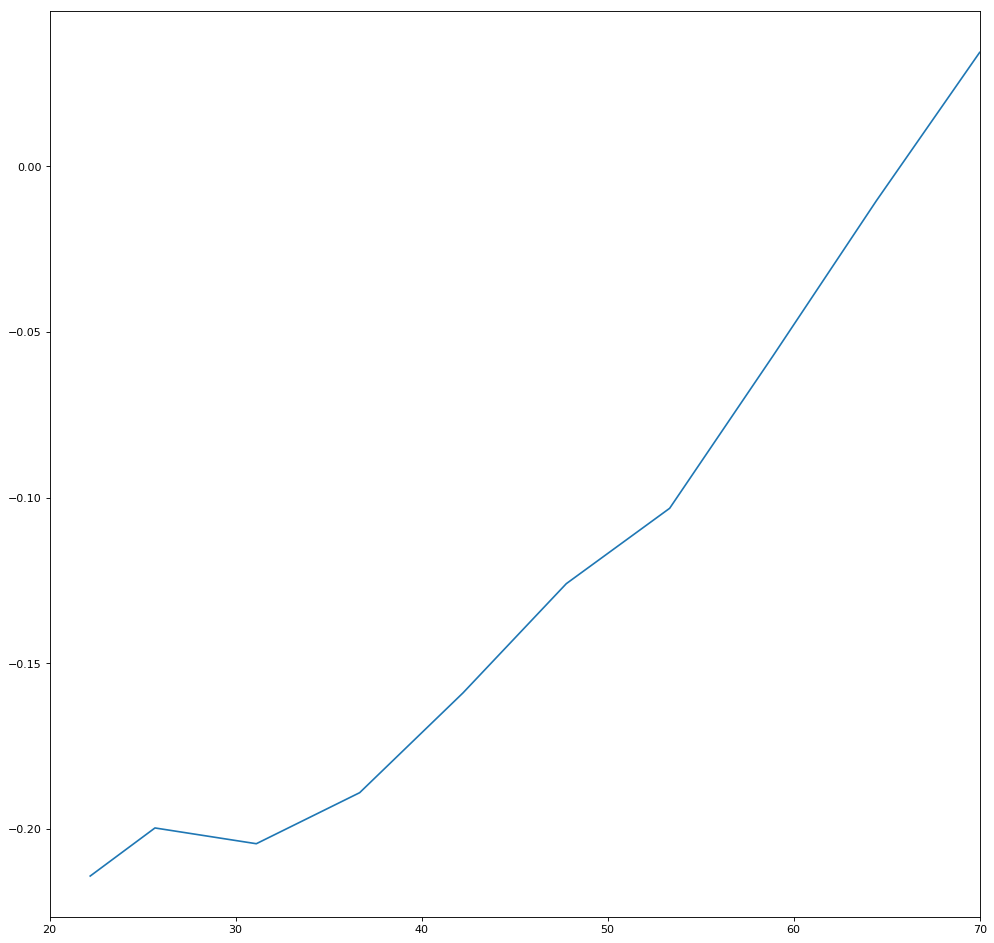

In [141]:
plt.figure(num=None, figsize=(15,15), dpi=80, facecolor='w', edgecolor='k')
for icom in range(1):
    plt.plot(QINT[icom,:],P_NN[NNname][icom,:])
    
plt.xlim((CWVmin,CWVmax))
#plt.ylim((0,50))